# the one used in paper

In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap
from itertools import combinations, product

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [3]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')
spec_file = os.path.join(morph_folder, 'specs_star.p')

# load all dfs

In [81]:
group_pred_all = pickle.load(open(os.path.join(results_folder, 'norm_robust', 'all_predicted.p'), 'rb'))
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav.p'), 'rb'))

In [65]:
all_groups = pd.concat([group_pred_all,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [66]:
all_groups.tail()

,index,min_val,max_val,slope,inflection,group,metric,subj
258,df,0.018225,0.951094,0.202028,48.683433,Group 3,behav,B1101
259,fg,0.086618,0.913664,1.151891,78.842110,Group 3,behav,B1222
260,fg,0.047706,0.976152,0.275545,76.420456,Group 3,behav,B1101
261,fh,0.066304,0.916032,0.231404,67.285280,Group 3,behav,B1222
262,fh,0.052882,0.980467,0.158747,74.250978,Group 3,behav,B1101


In [67]:
all_groups= all_groups.drop(all_groups[all_groups.metric=='frmse'].index).reset_index(drop=True)

In [68]:
all_groups.metric.unique()

array(['rmse', 'fcosine', 'behav'], dtype=object)

In [69]:
def get_formal_metric(x):
    if x['metric'] == 'rmse':
        return 'MSE'
    elif x['metric'] == 'behav':
        return 'Ground Truth'
    else:
        return 'APD'

In [70]:
all_groups['metric_formal'] = all_groups.apply(get_formal_metric, axis=1)

In [71]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric,subj,metric_formal
0,ae,1.000000e-16,1.000000,0.029875,79.470487,Group 1,rmse,NaN,MSE
1,af,1.000000e-16,0.568973,0.050084,67.639823,Group 1,rmse,NaN,MSE
2,ag,1.000000e-16,0.565611,0.057494,63.763143,Group 1,rmse,NaN,MSE
3,ah,1.000000e-16,1.000000,0.022960,125.997597,Group 1,rmse,NaN,MSE
4,be,1.000000e-16,0.980336,0.036597,100.000082,Group 1,rmse,NaN,MSE


(0.0, 1.0)

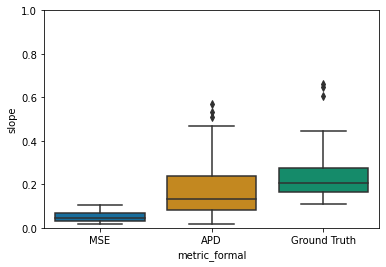

In [72]:
ax = sns.boxplot(y='slope', x='metric_formal',data=all_groups)
ax.set_ylim([0,1])

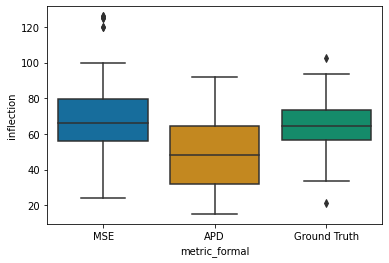

In [73]:
ax = sns.boxplot(y='inflection', x='metric_formal',data=all_groups)

In [74]:
import statsmodels.formula.api as smf

In [75]:
all_groups.subj.fillna(all_groups.metric_formal, inplace=True)

In [76]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric,subj,metric_formal
0,ae,1.000000e-16,1.000000,0.029875,79.470487,Group 1,rmse,MSE,MSE
1,af,1.000000e-16,0.568973,0.050084,67.639823,Group 1,rmse,MSE,MSE
2,ag,1.000000e-16,0.565611,0.057494,63.763143,Group 1,rmse,MSE,MSE
3,ah,1.000000e-16,1.000000,0.022960,125.997597,Group 1,rmse,MSE,MSE
4,be,1.000000e-16,0.980336,0.036597,100.000082,Group 1,rmse,MSE,MSE


In [77]:
all_groups['stim'] = all_groups['index']
all_groups.drop(columns=['index'], inplace=True)

In [78]:
model = smf.mixedlm("slope ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups,
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                          MixedLM             Dependent Variable:             slope    
No. Observations:               218                 Method:                         REML     
No. Groups:                     24                  Scale:                          0.3450   
Min. group size:                6                   Log-Likelihood:                 -198.9719
Max. group size:                10                  Converged:                      Yes      
Mean group size:                9.1                                                          
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           0.238    0.055  4.339 0.000  0.131  0.346
C(metric_formal, Treatment('Ground Truth'))[T.APD]  0.120    0.102  1.176 0.240 -0.080  0.319
C(metric_formal, Treatment('Ground Truth'))[T.MSE] -0.188    0.102 -1.841 0.066 -0.387  0.012
stim Var                                            0.008    0.024                           
=============================================================================================

"""

In [79]:
model = smf.mixedlm("slope ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
===========================================================================================================
Model:                               MixedLM                   Dependent Variable:                   slope 
No. Observations:                    218                       Method:                               REML  
No. Groups:                          3                         Scale:                                0.3504
Min. group size:                     60                        Log-Likelihood:                       inf   
Max. group size:                     96                        Converged:                            Yes   
Mean group size:                     72.7                                                                  
-----------------------------------------------------------------------------------------------------------
                                                   Coef.    Std.Err.    z    P>|z|    [0.025       0.975]  
-----------------------------------------------------------------------------------------------------------
Intercept                                           0.038 1811380.637  0.000 1.000 -3550240.773 3550240.850
C(metric_formal, Treatment('Ground Truth'))[T.APD]  0.125       0.103  1.210 0.226       -0.077       0.327
C(metric_formal, Treatment('Ground Truth'))[T.MSE] -0.182       0.103 -1.766 0.077       -0.385       0.020
group Var                                           0.000                                                  
===========================================================================================================

"""

In [80]:
model = smf.mixedlm("inflection ~ C(metric_formal, Treatment('Ground Truth'))",
                    all_groups,
                    groups= "stim").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                         MixedLM              Dependent Variable:              inflection
No. Observations:              218                  Method:                          REML      
No. Groups:                    24                   Scale:                           296.9557  
Min. group size:               6                    Log-Likelihood:                  -934.8137 
Max. group size:               10                   Converged:                       Yes       
Mean group size:               9.1                                                             
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                           63.534    2.166 29.338 0.000  59.289 67.778
C(metric_formal, Treatment('Ground Truth'))[T.APD] -13.599    2.996 -4.538 0.000 -19.472 -7.726
C(metric_formal, Treatment('Ground Truth'))[T.MSE]   6.680    2.996  2.229 0.026   0.807 12.553
stim Var                                            56.151    1.581                            
===============================================================================================

"""

In [91]:
model = smf.mixedlm("inflection ~ C(metric_formal, Treatment('Ground Truth'))",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Mixed Linear Model Regression Results
==============================================================================================================
Model:                              MixedLM                   Dependent Variable:                   inflection
No. Observations:                   222                       Method:                               REML      
No. Groups:                         3                         Scale:                                345.5999  
Min. group size:                    62                        Log-Likelihood:                       inf       
Max. group size:                    96                        Converged:                            Yes       
Mean group size:                    74.0                                                                      
--------------------------------------------------------------------------------------------------------------
                                                   Coef.    Std.Err.     z    P>|z|     [0.025       0.975]   
--------------------------------------------------------------------------------------------------------------
Intercept                                          -0.181 43019831.762 -0.000 1.000 -84317321.056 84317320.693
C(metric_formal, Treatment('Ground Truth'))[T.APD] -4.564        3.197 -1.428 0.153       -10.829        1.702
C(metric_formal, Treatment('Ground Truth'))[T.MSE]  3.635        3.197  1.137 0.255        -2.631        9.901
group Var                                           0.000                                                     
==============================================================================================================

"""

In [34]:
all_groups

,index,min_val,max_val,slope,inflection,group,metric,subj,metric_formal
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE
...,...,...,...,...,...,...,...,...,...
217,df,1.822476e-02,0.951094,0.202028,48.683433,Group 3,behav,B1101,Ground Truth
218,fg,8.661837e-02,0.913664,1.151891,78.842110,Group 3,behav,B1222,Ground Truth
219,fg,4.770582e-02,0.976152,0.275545,76.420456,Group 3,behav,B1101,Ground Truth
220,fh,6.630351e-02,0.916032,0.231404,67.285280,Group 3,behav,B1222,Ground Truth


In [35]:
all_groups['stim'] = all_groups['index']

In [36]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric,subj,metric_formal,stim
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE,ae
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE,af
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE,ag
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE,ah
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE,be


In [37]:
all_groups = all_groups.drop(columns=['index'])

# compare variability within behav

In [46]:
def subtract_behav(group_behav, item):
    def _subtract_behav(x):
        try:
            return np.abs(x[item]-group_behav[x['stim']][item])
        except:
            return np.NaN
    return _subtract_behav

In [59]:
group_df[group_df.metric_formal=='Ground Truth'][['stim', 'slope', 'inflection']].set_index('stim')

,slope,inflection
stim,,
ac,0.198839,71.647379
ac,0.200011,65.507034
ad,0.261339,79.149229
ad,0.143619,64.282696
ag,0.277552,60.857567
ag,0.381598,65.310582
ah,0.302839,79.469034
ah,0.153825,69.461061
bc,0.184492,69.725837


In [47]:
normalized_df = pd.DataFrame()
for group in ['Group 1', 'Group 2', 'Group 3']:
    group_df = all_groups[all_groups.group==group].reset_index(drop=True)
    group_behav = group_df[group_df.metric_formal=='Ground Truth'][['stim', 'slope', 'inflection']].set_index('stim').T.to_dict('stim')
    group_df['d_slope'] = group_df.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    group_df['d_inflection'] = group_df.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    normalized_df = pd.concat([normalized_df, group_df]).reset_index(drop=True)

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [57]:
normalized_df.tail()

,min_val,max_val,slope,inflection,group,metric,subj,metric_formal,stim,d_slope,d_inflection
217,0.018225,0.951094,0.202028,48.683433,Group 3,behav,B1101,Ground Truth,df,0.000000,0.000000
218,0.086618,0.913664,1.151891,78.842110,Group 3,behav,B1222,Ground Truth,fg,0.876346,2.421654
219,0.047706,0.976152,0.275545,76.420456,Group 3,behav,B1101,Ground Truth,fg,0.000000,0.000000
220,0.066304,0.916032,0.231404,67.285280,Group 3,behav,B1222,Ground Truth,fh,0.072658,6.965697
221,0.052882,0.980467,0.158747,74.250978,Group 3,behav,B1101,Ground Truth,fh,0.000000,0.000000


In [51]:
behav_df = all_groups[all_groups.metric_formal=='Ground Truth'].reset_index(drop=True)

In [52]:
behav_df.head()

,min_val,max_val,slope,inflection,group,metric,subj,metric_formal,stim
0,0.028412,0.988811,0.140918,45.110924,Group 1,behav,B979,Ground Truth,ae
1,0.063286,0.961973,0.166708,49.408209,Group 1,behav,B1107,Ground Truth,ae
2,0.034541,0.961020,0.126630,48.812577,Group 1,behav,B1082,Ground Truth,ae
3,0.015667,0.967891,0.128377,59.483561,Group 1,behav,B1218,Ground Truth,ae
4,0.048124,0.960810,0.111657,52.769747,Group 1,behav,B979,Ground Truth,af


In [53]:
group_stims = sorted(list(set(generate_group_stims('1')+generate_group_stims('2')+generate_group_stims('3'))))
d_slope_behav = []
d_inflection_behav = []
index_behav = []
                   
for stim in group_stims:
    stim_data = behav_df[behav_df['stim']==stim].reset_index(drop=True)
    stim_slopes = stim_data['slope'].values.tolist()
    stim_inflections = stim_data['inflection'].values.tolist()
    for i, j in combinations(range(len(stim_inflections)), 2):
        d_slope_behav.append(np.abs(stim_slopes[i]-stim_slopes[j]))
        d_inflection_behav.append(np.abs(stim_inflections[i]-stim_inflections[j]))
        index_behav.append(stim)

In [63]:
all_groups.head()

,min_val,max_val,slope,inflection,group,metric,subj,metric_formal,stim
0,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE,ae
1,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE,af
2,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE,ag
3,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE,ah
4,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE,be


In [73]:
group_stims = sorted(list(set(generate_group_stims('1')+generate_group_stims('2')+generate_group_stims('3'))))
d_slope_pred = []
d_inflection_pred = []
index_pred = []
metrics = []

for metric in ['APD', 'MSE']:

    for stim in group_stims:
        stim_data = behav_df[behav_df['stim']==stim].reset_index(drop=True)
        stim_slopes = stim_data['slope'].values.tolist()
        stim_inflections = stim_data['inflection'].values.tolist()

        stim_data_pred = all_groups[(all_groups.stim==stim) & (all_groups.metric_formal==metric)].reset_index(drop=True)
        stim_slopes_pred = stim_data_pred['slope'].values.tolist()
        stim_inflections_pred = stim_data_pred['inflection'].values.tolist()
        
        for pred_i, behav_i in product(range(len(stim_slopes_pred)), range(len(stim_slopes))):
            d_slope_pred.append(np.abs(stim_slopes_pred[pred_i]-stim_slopes[behav_i]))
            d_inflection_pred.append(np.abs(stim_inflections_pred[pred_i]-stim_inflections[behav_i]))
            index_pred.append(stim)
            metrics.append(metric)

In [74]:
pred_df_d = pd.DataFrame({'stim':index_pred, 'd_slope':d_slope_pred, 'd_inflection':d_inflection_pred, 'metric': metrics})

In [75]:
pred_df_d

,stim,d_slope,d_inflection,metric
0,ac,0.060439,38.439016,APD
1,ac,0.088363,45.439869,APD
2,ac,0.070407,46.313563,APD
3,ac,0.069235,40.173218,APD
4,ac,0.023868,38.868974,APD
...,...,...,...,...
495,fh,0.099788,36.812461,MSE
496,fh,0.181345,1.940946,MSE
497,fh,0.136727,23.506055,MSE
498,fh,0.172445,29.846764,MSE


In [64]:
behav_df_d = pd.DataFrame({'stim':index_behav, 'd_slope':d_slope_behav, 'd_inflection':d_inflection_behav})

In [66]:
behav_df_d['metric'] = 'Ground Truth'

In [67]:
behav_df_d

,stim,d_slope,d_inflection,metric
0,ac,0.148802,7.000853,Ground Truth
1,ac,0.009968,7.874547,Ground Truth
2,ac,0.008796,1.734202,Ground Truth
3,ac,0.158771,0.873694,Ground Truth
4,ac,0.157598,5.266651,Ground Truth
...,...,...,...,...
283,fh,0.008899,27.905818,Ground Truth
284,fh,0.081557,34.871515,Ground Truth
285,fh,0.035718,6.340708,Ground Truth
286,fh,0.036940,13.306406,Ground Truth


In [86]:
behav_df_d.mean()

d_slope          0.094857
d_inflection    10.825917
dtype: float64

# compare normalized data vs behavior variability

In [76]:
all_d = pd.concat([behav_df_d, pred_df_d]).reset_index(drop=True)

In [77]:
all_d

,stim,d_slope,d_inflection,metric
0,ac,0.148802,7.000853,Ground Truth
1,ac,0.009968,7.874547,Ground Truth
2,ac,0.008796,1.734202,Ground Truth
3,ac,0.158771,0.873694,Ground Truth
4,ac,0.157598,5.266651,Ground Truth
...,...,...,...,...
783,fh,0.099788,36.812461,MSE
784,fh,0.181345,1.940946,MSE
785,fh,0.136727,23.506055,MSE
786,fh,0.172445,29.846764,MSE


In [81]:
model = smf.mixedlm("d_slope ~ C(metric, Treatment('Ground Truth'))",
                    all_d,
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM           Dependent Variable:           d_slope 
No. Observations:           788               Method:                       REML    
No. Groups:                 24                Scale:                        0.0233  
Min. group size:            22                Log-Likelihood:               323.5800
Max. group size:            39                Converged:                    Yes     
Mean group size:            32.8                                                    
------------------------------------------------------------------------------------
                                            Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                   0.101    0.022 4.687 0.000  0.059  0.143
C(metric, Treatment('Ground Truth'))[T.APD] 0.097    0.013 7.326 0.000  0.071  0.123
C(metric, Treatment('Ground Truth'))[T.MSE] 0.090    0.013 6.770 0.000  0.064  0.116
stim Var                                    0.009    0.020                          
====================================================================================

"""

In [82]:
from scipy.stats import ttest_ind

In [83]:
d_slope_GT = all_d[all_d.metric=='Ground Truth'].d_slope.values.tolist()
d_slope_APD = all_d[all_d.metric=='APD'].d_slope.values.tolist()
d_slope_MSE = all_d[all_d.metric=='MSE'].d_slope.values.tolist()
ttest_ind(d_slope_GT, d_slope_APD)

Ttest_indResult(statistic=-6.038742578742818, pvalue=2.904657942174955e-09)

In [85]:
ttest_ind(d_slope_GT, d_slope_MSE)

Ttest_indResult(statistic=-8.53186836906168, pvalue=1.482284770191487e-16)

(0.0, 1.0)

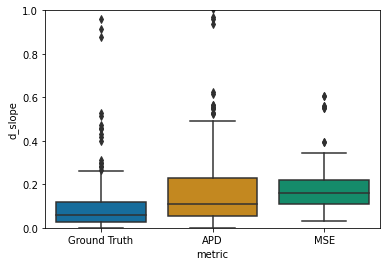

In [78]:
ax = sns.boxplot(y='d_slope', x='metric',data=all_d)
ax.set_ylim([0,1])

In [80]:
model = smf.mixedlm("d_inflection ~ C(metric, Treatment('Ground Truth'))",
                    all_d,
                    groups= "stim").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                      MixedLM          Dependent Variable:          d_inflection
No. Observations:           788              Method:                      REML        
No. Groups:                 24               Scale:                       143.5296    
Min. group size:            22               Log-Likelihood:              -3104.3033  
Max. group size:            39               Converged:                   Yes         
Mean group size:            32.8                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                   11.979    1.892  6.332 0.000  8.271 15.687
C(metric, Treatment('Ground Truth'))[T.APD] 11.102    1.041 10.665 0.000  9.062 13.142
C(metric, Treatment('Ground Truth'))[T.MSE]  7.218    1.041  6.934 0.000  5.178  9.258
stim Var                                    73.267    1.970                           
======================================================================================

"""

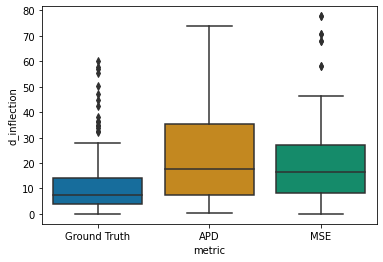

In [79]:
ax = sns.boxplot(y='d_inflection', x='metric',data=all_d)